In [1]:

#!/usr/bin/env python
# coding: utf-8

from matplotlib import cm
from sympy import Matrix
import sympy as sm
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import json
from time import time

import wandb

################### check tensorflow is using GPU ###################
from tensorflow.python.client import device_lib
physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
print(device_lib.list_local_devices())
# what if empty...
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# On windows systems you cannont install NCCL that is required for multi GPU
# So we need to follow hierarchical copy method or reduce to single GPU (less efficient than the former)
strategy = tf.distribute.MirroredStrategy(
    devices=['GPU:0'], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

DTYPE = 'float32'

tf.keras.backend.set_floatx(DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)

################### proper to the computer used ###################
__file__ = 'C:/Users/jtros/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

print('\ncwd:', os.getcwd())
os.chdir(__file__)
print('changed to:', os.getcwd(), '\n')


################### Create the model ###################

def generate_model(l_units, noise=False, dropout_rate=0):
    # méthode API Sequential
    n_hidden = len(l_units)
    model = keras.models.Sequential([
        keras.layers.Input(shape=(2))
    ])
    if noise:
        model.add(keras.layers.GaussianNoise(stddev=1e-4))
    for i in range(n_hidden):
        model.add(keras.layers.Dropout(dropout_rate))
        model.add(keras.layers.Dense(
            l_units[i], activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(1, use_bias=False)) 
    # use_bias=False otherwise returns error after
    # May be the cause of a stagnation in the validation ? (can circumvent by creating a layer class only adding a bias)
    model.summary()
    return model

def generate_model_1(l_units,noise=False):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    lb = 0
    ub = 1
    scaling_layer = tf.keras.layers.Lambda(
        lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    n_hidden = len(l_units)
    for i_hid in range(n_hidden):
        model.add(tf.keras.layers.Dense(l_units[i_hid],
                                        activation=tf.keras.activations.get(
                                            'tanh'),
                                        kernel_initializer='glorot_normal')) #, kernel_regularizer='l2'

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1, use_bias=False))
    model.summary()
    return model

def test_0():
    generate_model([30])

################### define the EDP to solve ###################
# Given EDO
def f(X):
    return tf.sin(pi*X[:, 0])*tf.sin(pi*X[:, 1])


def boundary_conditions(X):
    return 0


def residual(du_dxx, du_dyy, f_ind):
    return du_dxx+du_dyy+f_ind


def differentiate(model, x, training=False):
    with tf.GradientTape(persistent=True) as tape:
        x1, x2 = x[:, 0:1], x[:, 1:2]
        tape.watch(x1)
        tape.watch(x2)
        u = model(tf.stack([x1[:, 0], x2[:, 0]], axis=1),training=training)
        du_dx = tape.gradient(u, x1)
        du_dy = tape.gradient(u, x2)
    du_dxx = tape.gradient(du_dx, x1)
    du_dyy = tape.gradient(du_dy, x2)
    return du_dx, du_dxx, du_dy, du_dyy



#######################################################################################################
################### Method 3: g automatically respects the boundary conditions ########################
# article : 1997_Artificial_neural_networks_for_solving_ordinary_and_partial_differential_equations.pdf

################### Set F here ###################
# Dummy F


x, y = sm.symbols('x,y')


def expr_dummy_F():
    return x*(1-x)*y*(1-y)


expr_F = expr_dummy_F()
dexpr_F_dx = sm.diff(expr_F, x, 1)
dexpr_F_dxx = sm.diff(dexpr_F_dx, x, 1)
dexpr_F_dy = sm.diff(expr_F, y, 1)
dexpr_F_dyy = sm.diff(dexpr_F_dy, y, 1)


# remark: You can forget a no lambdified expression => here we greatly avoid 'for' loops

expr_F = sm.lambdify([x, y], Matrix([expr_F]), 'numpy')
dexpr_F_dx = sm.lambdify([x, y], Matrix([dexpr_F_dx]), 'numpy')
dexpr_F_dxx = sm.lambdify([x, y], Matrix([dexpr_F_dxx]), 'numpy')
dexpr_F_dy = sm.lambdify([x, y], Matrix([dexpr_F_dy]), 'numpy')
dexpr_F_dyy = sm.lambdify([x, y], Matrix([dexpr_F_dyy]), 'numpy')


def evaluate_F_and_diff(X):
    F = tf.squeeze(tf.transpose(expr_F(X[:, 0], X[:, 1])), axis=-1)
    dF_dx = tf.expand_dims(dexpr_F_dx(X[:, 0], X[:, 1]), axis=-1)
    dF_dxx = tf.expand_dims(dexpr_F_dxx(X[:, 0], X[:, 1]), axis=-1)
    dF_dy = tf.expand_dims(dexpr_F_dy(X[:, 0], X[:, 1]), axis=-1)
    dF_dyy = tf.expand_dims(dexpr_F_dyy(X[:, 0], X[:, 1]), axis=-1)

    return F, dF_dx, dF_dxx, dF_dy, dF_dyy

 # oddly enough expr_F and dexpr_F_d... do not have the same output


# # #### F of F_functions


# frontier_coords = Pstud._set_coords_rectangle(1, 1, 10)

# l_orders = [(1, 0), (2, 0), (0, 1), (0, 2)]
# strfn = 'sinxpy_real'
# F = F2D(frontier_coords, strfn, l_orders=l_orders)

# # prepare to infer on large matrices :
# F.expr = sm.lambdify(F.variables, Matrix([F.expr]), 'numpy')
# for t_order in l_orders:
#     F.reduced_tab_diff[F.dico_order_to_index[t_order]] = sm.lambdify(
#         F.variables, F.reduced_tab_diff[F.dico_order_to_index[t_order]], 'numpy')


# def evaluate_F_and_diff(X):
#     '''
#     evaluate F and its differentiates get in F.reduced_tab_diff
#     Variables:
#     -X: an array or tensor tf of the coordinates

#     Returns:
#     -l_eval: list of the evaluations. To know which element corresponds to which order, use F.dico_order_to_index and increment the values of 1.

#     remark: to add to F2D class
#     '''
#     l_eval = [tf.squeeze(tf.transpose(F.expr(X[:, 0], X[:, 1])), axis=-1)]

#     for i, t_order in enumerate(F.reduced_tab_diff):
#         l_eval.append(tf.expand_dims(
#             F.reduced_tab_diff[i](X[:, 0], X[:, 1]), axis=-1))

#     return l_eval



################### Set A here ###################

A = 0
dA_dxx = 0
dA_dyy = 0


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6018590112396097159
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5730467840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9405711379057346696
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

cwd: c:\Users\jtros\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami\differentiate
changed to: C:\Users\jtros\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami 



In [ ]:
def try_config(config,id_add, use_wandb=False):
    '''
    A run of the full algorithm described in the paper of 1997. 
    Variables:
    -config (dict): The hyperparameters used to construct the model and set the training loop are in config.
    -id_add (int): add id_add to the trial_id to avoid overwriting previous trials 
    '''
    print('config:\n',config)
    config_model = config['config_model']
    config_training = config['config_training']

    l_units = config_model['l_units']
    noise = config_model['noise']
    dropout_rate = config_model['dropout_rate']

    trial_id = config['trial_id']+id_add

    if use_wandb:
        wandb.init(
            project="TF-tsunami",
            name=f'trial_{trial_id}',
            config=config)
        
    # generate model
    if config_model['save_path']=='':
        model = generate_model(l_units, noise=noise, dropout_rate=dropout_rate)
    else:
        model = keras.models.load_model(config_model['save_path'])

    lr_max = config_model['learning_rate']['lr_max']
    lr_min = config_model['learning_rate']['lr_min']
    lr_middle = config_model['learning_rate']['lr_middle']
    step_middle =  config_model['learning_rate']['step_middle']
    step_min = config_model['learning_rate']['step_min']
    if config_model['optimizer'] == "Adam":
        if config_model['learning_rate']['scheduler']:
            lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                [step_middle, step_min], [lr_max, lr_middle, lr_min])
        else:
            lr = lr_max

        # Choose the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
    else:
        print('optimizer is not known !')

    


    # Universal Approximator
    # @tf.function  # TODO: learn to use it to accelerate the computations
    def g_3(X, training=True):
        # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
        N_X = model(X, training=training)
        return tf.squeeze(tf.transpose(expr_F(X[:, 0], X[:, 1])), axis=-1)*N_X


    # Custom loss function to approximate the derivatives

    def custom_loss_3(tf_sample_coords):
        dN_dx, dN_dxx, dN_dy, dN_dyy = differentiate(
            model, tf_sample_coords,training=True)
        f_r = tf.reshape(f(tf_sample_coords), [batch_size, 1])

        F, dF_dx, dF_dxx, dF_dy, dF_dyy = evaluate_F_and_diff(tf_sample_coords)

        dg_dxx = dF_dxx + 2*dF_dx*dN_dx + F*dN_dxx + dA_dxx
        dg_dyy = dF_dyy + 2*dF_dy*dN_dy + F*dN_dyy + dA_dyy
        res = residual(dg_dxx, dg_dyy, f_r)

        loss = tf.reduce_mean(tf.square(res))
        return loss

    # train of method 3:

    def train_step_3(tf_sample_coords,lr):
        with tf.GradientTape() as tape:
            loss = custom_loss_3(tf_sample_coords)
        trainable_variables = model.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss


    mae_metric = tf.keras.metrics.MeanAbsoluteError(
        name="mean_absolute_error", dtype=None)


    def validate(validation_coords):
        _, dg_dxx, _, dg_dyy = differentiate(g_3, validation_coords,training=False)
        f_r = tf.reshape(f(validation_coords), [tf.shape(validation_coords)[0], 1])
        res = residual(dg_dxx, dg_dyy, f_r)
        val_mae = mae_metric(res, tf.zeros(tf.shape(res))).numpy()
        return val_mae


    def lr_scheduler(lr_max,lr_min,k,n_trains):
        return (lr_max-lr_min)*np.exp(-10*k/(n_trains+1))+lr_min
        
    # Training the Model of method 3:


    trial_id = config['trial_id']+id_add
    epochs_max = config_training['epochs_max']
    n_trains = config_training['n_trains']
    batch_size = config_training['batch_size']
    val_size = config_training['val_size']
    display_step = config_training['display_step']
    tol = config_training['tol']
    patience = config_training['patience']



    ## !!! to change according to the way the folders are arranged
    folder_dir = f'differentiate/hypertuning/byHand/trial_{trial_id}/'



    # TODO: learn how to use Yaml instead... (piece of advice from Jules S.)

    if not(os.path.exists(folder_dir)):
        os.mkdir(folder_dir)
    with open(folder_dir+f'config_{trial_id}.json', 'w') as fp:
        json.dump(config, fp, indent=4)



    history = {'mean_loss': [], 'val_mae': []}

    epoch = 0
    val_mae = np.infty
    val_mae_reached = (val_mae <= tol)
    EarlyStopped = False

    # tf.keras.backend.set_learning_phase(1) # 'globally' activate training mode, slightly too strong maybe : check training mode for GaussianNoise layer
    
    total_duration = 0
    while not(EarlyStopped) and not(val_mae_reached) and epoch < epochs_max:
        epoch += 1
        time_start = time()
        print('epoch:', epoch)
        losses = []

        # indices = np.random.randint(tf_coords.shape[0], size=batch_size)
        # tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])
        
        tf_sample_coords = tf.random.uniform((batch_size,2),0,1)
        for k in range(n_trains):
            # lr = lr_scheduler(lr_max,lr_min,k,n_trains)
            loss = train_step_3(tf_sample_coords,lr)
            losses.append(loss)
            if k % display_step == 0:
                print('epoch:', epoch, 'train step:', k, 'loss:',loss.numpy())
                if use_wandb:
                    wandb.log({'train_loss':loss})
        mean_loss = np.mean(losses)

        if use_wandb:
            wandb.log({'mean_loss':mean_loss})

        # create validation_coords
        tf_val_coords = tf.random.uniform((val_size,2),0,1)
        val_mae = validate(tf_val_coords)

        if use_wandb:
            wandb.log({'val_mae':val_mae})

        print("mean_loss:", mean_loss, end=' ')
        print('val_mae:', val_mae, end=' ')
        history['mean_loss'].append(mean_loss)
        history['val_mae'].append(val_mae)

        # time_end_training = time()
        # print('duration training :', time_end_training-time_start, end=' ')

        val_mae_reached = (val_mae <= tol)

        if val_mae_reached:
            print(f'\n tolerance set is reached : {val_mae}<={tol}')

        model.save(
            folder_dir+f'model_poisson_trial_{trial_id}_epoch_{epoch}_val_mae_{val_mae:6f}.h5')

        if (len(history['val_mae']) >= patience+1) and np.argmin(history['val_mae'][-(patience+1):]) == 0:
            print('\n EarlyStopping activated', end = ' ')
            EarlyStopped = True
            

        elif (len(history['val_mae']) >= patience+1):
            # clean the savings folder
            r_val_mae_epoch = epoch-patience
            r_val_mae = history['val_mae'][-(patience+1)]
            file_path = folder_dir + \
                f'model_poisson_trial_{trial_id}_epoch_{r_val_mae_epoch}_val_mae_{r_val_mae:6f}.h5'

            if os.path.exists(file_path):
                os.remove(file_path)
            else:
                print(file_path)
                print("The system cannot find the file specified")

        time_end_epoch = time()
        duration_epoch = time_end_epoch-time_start
        total_duration+=duration_epoch
        print('duration epoch:', duration_epoch)
        print()

    if use_wandb:
        wandb.finish()

    print('end of the epochs',end=' ')
    print('total_duration:',total_duration)

    # not optimized
    min_val_mae = np.min(history['val_mae'])
    min_val_mae_epoch = np.argmin(history['val_mae'])+1


    model = keras.models.load_model(folder_dir+f'model_poisson_trial_{trial_id}_epoch_{min_val_mae_epoch}_val_mae_{min_val_mae:6f}.h5')
    os.rename(folder_dir+f'model_poisson_trial_{trial_id}_epoch_{min_val_mae_epoch}_val_mae_{min_val_mae:6f}.h5', folder_dir+f'best_model_poisson_trial_{trial_id}_epoch_{min_val_mae_epoch}_val_mae_{min_val_mae:6f}.h5')
    print('best model loaded and renamed')

    # tf.keras.backend.set_learning_phase(0) # 'globally' disable training mode
    print("val_mae>tol:", val_mae > tol)

    plt.plot(np.arange(0, epoch), history['mean_loss'], label='mean_loss')
    plt.plot(np.arange(0, epoch), history['val_mae'], label='val_mae')
    # plt.ylabel('mean_loss')
    plt.xlabel('epoch')
    plt.title(
        f'epochs_max = {epochs_max},n_trains={n_trains},batch_size={batch_size}')
    plt.legend()
    plt.savefig(folder_dir+f"history_trial_{trial_id}.png",transparent=False)
    print(folder_dir+f"history_trial_{trial_id}.png")

    print(np.min(history['val_mae']))


# Does not learn with F = F2D(..., 'sinxpy_real') or 'xpy_real'
# - take a look at dF_dx and so on
# - ... at the hyperparameters
# -




# # Questions

# Quelle architecture ?
#
# Comment éviter l'overfitting ?
#
# Comment exploiter les avantages de l'IA ?
#
# Choix de l'optimizer + regularizer ? + Implémentation ?
#
# Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ? (Est-ce que c'est utile ça ? Par curiosité)
#
# Plus rapide ? Comment enlever les boucles `for` ? => mini_batch_gradient_descent ? done
#
# Besoin de batch_normalization ? + autres hyperparamètres ?

# # Idées

# Ajout de bruit en entrée contre l'overfitting
#
# Une sortie par inconnue

# %%


In [ ]:
# a few train parameters to adjust
# use learning_rate = 1e-2, batch_size = 1000 for dummy F
###############
def generate_random_config(trial_id):
    n_hidden_layers = np.random.randint(2,7)
    l_units = [5*np.random.randint(1,7) for _ in range(n_hidden_layers)]
    noise = np.random.randint(2)

    config_model = {
        'l_units': l_units,
        'noise': noise,
        'learning_rate': {"lr_max" : 1e-4 ,"lr_min" : 1e-6, 'scheduler':0},
        'optimizer': "Adam"
    }


    n_trains = 50*np.random.randint(2,5)
    config_training = {
        "epochs_max": 5000,
        "n_trains": n_trains,
        "batch_size": 8192,
        "display_step": 10,
        "tol": 1e-6,
        "patience": 50
    }

    config = {
        "trial_id": trial_id,
        "config_training": config_training,
        "config_model": config_model
    }
    
    return config

max_trials = 100
id_add=100
def randomTuning(max_trials,id_add):
    for trial_id in range(max_trials):
        config = generate_random_config(trial_id)
        try_config(config,id_add=id_add)

randomTuning(max_trials,id_add) ############

In [11]:
# tf.random.set_seed(42)

config_model = {
        'l_units': [30,30],
        'noise': 0,
        'dropout_rate':0.2,
        'learning_rate': {'scheduler':0,"lr_max" : 1e-5 ,"lr_middle":1e-7,"lr_min" :1e-9, 'step_middle':1300,'step_min':3000},
        'optimizer': "Adam",
        'save_path':'differentiate/hypertuning/byHand/trial_100/model_poisson_trial_100_epoch_2_val_mae_0.408173.h5'
    }


config_training = {
        "epochs_max": 100,
        "n_trains": 5000,
        "batch_size": 8192,
        "val_size":8192,
        "display_step": 50,
        "tol": 1e-6,
        "patience": 100
    }

config = {
        "trial_id": 8,
        'remark':'',
        "config_training": config_training,
        "config_model": config_model
    }

try_config(config,id_add=100,use_wandb=True)

config:
 {'trial_id': 8, 'remark': '', 'config_training': {'epochs_max': 100, 'n_trains': 5000, 'batch_size': 8192, 'val_size': 8192, 'display_step': 10, 'tol': 1e-06, 'patience': 100}, 'config_model': {'l_units': [30, 30], 'noise': 0, 'dropout_rate': 0.2, 'learning_rate': {'scheduler': 0, 'lr_max': 1e-05, 'lr_middle': 1e-07, 'lr_min': 1e-09, 'step_middle': 1300, 'step_min': 3000}, 'optimizer': 'Adam', 'save_path': 'differentiate/hypertuning/byHand/trial_100/model_poisson_trial_100_epoch_2_val_mae_0.408173.h5'}}


train_loss,██▇▇▆▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.01156


epoch: 1
epoch: 1 train step: 0 loss: 0.014059396
epoch: 1 train step: 10 loss: 0.014026806
epoch: 1 train step: 20 loss: 0.014002731
epoch: 1 train step: 30 loss: 0.013982938
epoch: 1 train step: 40 loss: 0.013958553
epoch: 1 train step: 50 loss: 0.013967091
epoch: 1 train step: 60 loss: 0.013968739
epoch: 1 train step: 70 loss: 0.013962447
epoch: 1 train step: 80 loss: 0.01396305
epoch: 1 train step: 90 loss: 0.013964791
epoch: 1 train step: 100 loss: 0.013945106
epoch: 1 train step: 110 loss: 0.013940291
epoch: 1 train step: 120 loss: 0.01392695
epoch: 1 train step: 130 loss: 0.0139086805
epoch: 1 train step: 140 loss: 0.013890728
epoch: 1 train step: 150 loss: 0.013874942
epoch: 1 train step: 160 loss: 0.013856322
epoch: 1 train step: 170 loss: 0.013825407
epoch: 1 train step: 180 loss: 0.013816733
epoch: 1 train step: 190 loss: 0.013788924
epoch: 1 train step: 200 loss: 0.013771466
epoch: 1 train step: 210 loss: 0.013759216
epoch: 1 train step: 220 loss: 0.01375786
epoch: 1 train 

KeyboardInterrupt: 

np.max(error): 0.2013346


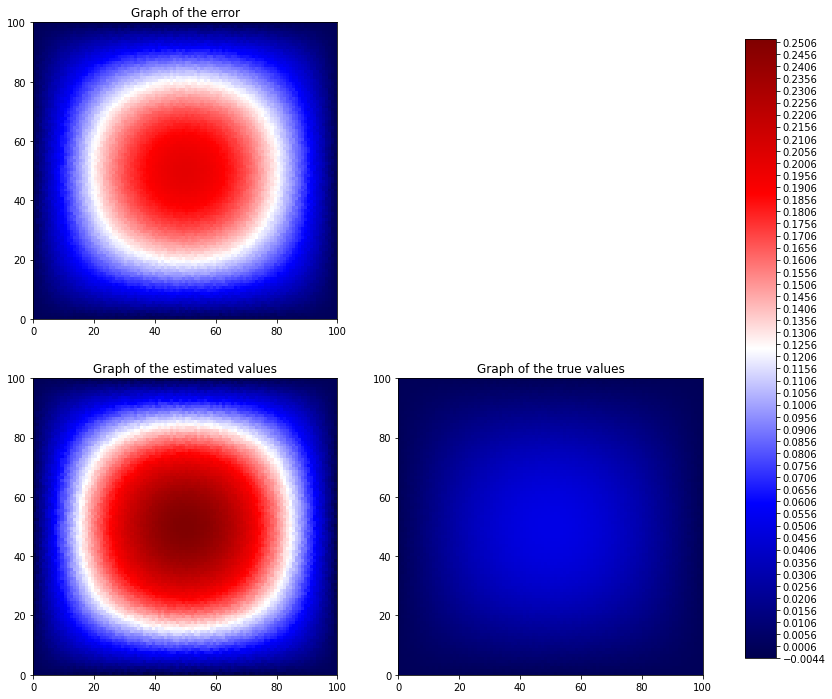

In [79]:
from matplotlib import cm

model = keras.models.load_model('differentiate/hypertuning/byHand/trial_100/model_poisson_trial_100_epoch_3_val_mae_0.282173.h5')

grid_length = 100
X = np.linspace(0,1,grid_length, endpoint=True)
Y = np.linspace(0,1,grid_length, endpoint=True)
tf_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in X for y in Y])
tf_boundary_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in [0,1] for y in Y ] + [tf.constant([x,y],dtype=DTYPE) for y in [0,1] for x in X ])  

def true_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(2*np.pi**2)

# to check that the model is not overfitting
# Rk: may blur the cmapping then
noise = (tf.random.uniform((grid_length**2,2))-0.5)/grid_length

tf_noisy_coords = tf_coords+noise
true_values = tf.reshape(true_function(tf_noisy_coords),[100,100]).numpy()
appro_values = tf.reshape(g_3(tf_noisy_coords,training=False),[100,100]).numpy()            
# change g according to the method applied
# no @tf.function above g_3...
error = np.abs(true_values-appro_values)



print('np.max(error):',np.max(error))
#print(error.shape)

combined_data = [error, appro_values, true_values]
_min,_max = np.min(combined_data), np.max(combined_data)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

seismic = cm.get_cmap('seismic', 1024)

plt.subplot(221)
plt.pcolormesh(error, cmap = seismic,vmin=_min,vmax=_max)
plt.title('Graph of the error')

ax = axes.flat[1]
ax.set_axis_off()

plt.subplot(223)
plt.pcolormesh(appro_values, cmap = seismic,vmin=_min,vmax=_max)
plt.title('Graph of the estimated values')

plt.subplot(224)
im = plt.pcolormesh(true_values, cmap = seismic, vmin=_min,vmax=_max)
plt.title('Graph of the true values')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

cbar.set_ticks(np.arange(_min,_max+1e-10, 0.5e-2))